In [16]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import load_dataset

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janczarnecki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/janczarnecki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/janczarnecki/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
# Books
book_df = pd.read_csv('datasets_files/book-reviews.csv', encoding='ISO-8859-1')
book_df = book_df.rename(columns={book_df.columns[0]: 'text'})
book_df['topic'] = 'book'

# Movies 
def load_movie_reviews(path, sentiment):
    files = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), encoding='ISO-8859-1') as f:
            files.append({'text': f.read(), 'sentiment': sentiment})
    return pd.DataFrame(files)

movie_pos = load_movie_reviews('datasets_files/movie-training-set-polarity/pos', 'positive')
movie_neg = load_movie_reviews('datasets_files/movie-training-set-polarity/neg', 'negative')
movie_df = pd.concat([movie_pos, movie_neg], ignore_index=True)
movie_df['topic'] = 'movie'

# Sports
ds = load_dataset("datadreamer-dev/cnn_dailymail_sports")
sports_texts = [x['article'] for x in ds['train']]
sports_df = pd.DataFrame({'text': sports_texts, 'topic': 'sports'})

# Downsample 
min_class_size = min(len(movie_df), len(sports_df))
book_df = book_df.sample(n=min_class_size, random_state=42).reset_index(drop=True)
movie_df = movie_df.sample(n=min_class_size, random_state=42).reset_index(drop=True)
sports_df = sports_df.sample(n=min_class_size, random_state=42).reset_index(drop=True)

# Combine all
train_df = pd.concat([book_df[['text', 'topic']], movie_df[['text', 'topic']], sports_df[['text', 'topic']]], ignore_index=True)
test_df = pd.read_csv('sentiment-topic-test.tsv', sep='\t')

In [18]:
# Lowercase, remove non-alphabetic characters, tokenize, remove stopwords, and lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

train_df['clean'] = train_df['text'].apply(preprocess)
test_df['clean'] = test_df['sentence'].apply(preprocess)

In [19]:
# NMF

n_topics = train_df['topic'].nunique() 

param_grid = {
    'max_df': [0.9, 0.95],
    'min_df': [1, 2]}

best_score = np.inf
best_params = {}

for max_df in param_grid['max_df']:
    for min_df in param_grid['min_df']:
        tfidf = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
        X = tfidf.fit_transform(train_df['clean'])

        nmf = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=200)
        nmf.fit(X)
        score = nmf.reconstruction_err_

        if score < best_score:
            best_score = score
            best_params = {'max_df': max_df,
                           'min_df': min_df,
                           'n_components': n_topics}


print("Best params:", best_params, "with reconstruction error", best_score)


Best params: {'max_df': 0.9, 'min_df': 2, 'n_components': 3} with reconstruction error 11.181553312447935


In [20]:
# Fit final model with best parameters
tfidf = TfidfVectorizer(max_df=best_params['max_df'], min_df=best_params['min_df'], stop_words='english')
X_train = tfidf.fit_transform(train_df['clean'])

nmf = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=200)
W_train = nmf.fit_transform(X_train)
H = nmf.components_

In [21]:
# Display learned topics
feature_names = tfidf.get_feature_names_out()
def display_topics(H, feature_names, num_top_words=10):
    for idx, topic in enumerate(H):
        top_idx = topic.argsort()[:-num_top_words-1:-1]
        terms = [feature_names[i] for i in top_idx]
        print(f"Topic {idx}: ", ", ".join(terms))

display_topics(H, feature_names)


Topic 0:  film, movie, like, character, good, make, story, plot, life, michael
Topic 1:  book, read, character, kept, rachel, reading, good, author, train, story
Topic 2:  said, hernandez, game, team, league, lloyd, player, police, sport, club


In [22]:
# Predict topics on test set
test_X = tfidf.transform(test_df['clean'])
W_test = nmf.transform(test_X)
test_pred = np.argmax(W_test, axis=1)

In [23]:
clusters = np.unique(test_pred)
topics = test_df['topic'].unique()

# Build confusion matrix between clusters and true topics
confusion = np.zeros((len(clusters), len(topics)), dtype=int)
for i, cluster in enumerate(clusters):
    actuals = test_df.loc[test_pred == cluster, 'topic']
    counts = Counter(actuals)
    for j, topic in enumerate(topics):
        confusion[i, j] = counts[topic]

# Assign each cluster to unique topic 
assigned_topics = set()
cluster_to_label = {}
for _ in range(len(clusters)):
    i, j = np.unravel_index(confusion.argmax(), confusion.shape)
    cluster_to_label[clusters[i]] = topics[j]
    assigned_topics.add(topics[j])
    confusion[i, :] = -1  
    confusion[:, j] = -1  

print("Cluster to label mapping:", cluster_to_label)

Cluster to label mapping: {0: 'movie', 1: 'book', 2: 'sports'}


In [24]:
# Assign predicted labels
test_df['predicted_topic'] = [cluster_to_label[c] for c in test_pred]

In [25]:
# Evaluation
print(classification_report(test_df['topic'], test_df['predicted_topic']))
print("Confusion Matrix:\n", confusion_matrix(test_df['topic'], test_df['predicted_topic']))

              precision    recall  f1-score   support

        book       1.00      1.00      1.00         6
       movie       1.00      1.00      1.00         6
      sports       1.00      1.00      1.00         6

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

Confusion Matrix:
 [[6 0 0]
 [0 6 0]
 [0 0 6]]


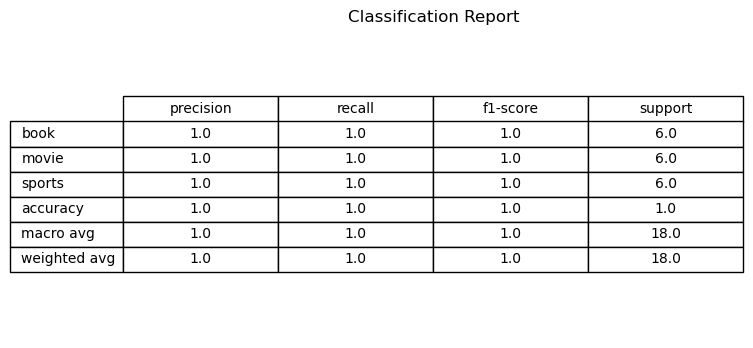

In [26]:
# Generate classification report 
report = classification_report(test_df['topic'], test_df['predicted_topic'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot as table for img
fig, ax = plt.subplots(figsize=(8, len(report_df)*0.5 + 1))
ax.axis('off')
tbl = ax.table(cellText=np.round(report_df.values, 2), colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)
plt.title('Classification Report')
plt.savefig('classification_report.png', bbox_inches='tight', dpi=150)
plt.show()

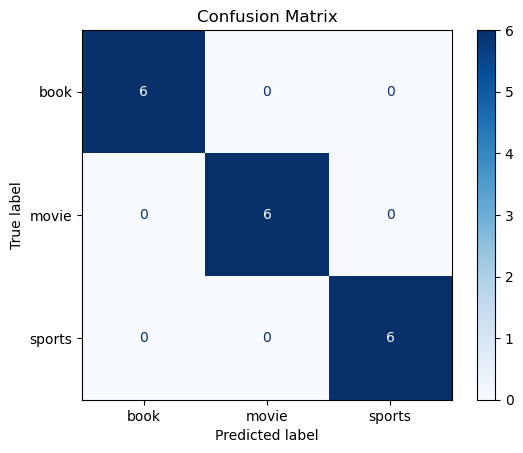

In [27]:
# Confusion matrix for img
cm = confusion_matrix(test_df['topic'], test_df['predicted_topic'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_df['topic']))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

In [28]:
# Save test sentences with real topic labels and sentiment

test_df['predicted_topic_label'] = test_df['predicted_topic']


test_df[['sentence', 'predicted_topic_label']].to_csv('test_sentences_with_single_topic_label_and_sentiment.csv', index=False)
print("Saved to test_sentences_with_single_topic_label_and_sentiment.csv")

Saved to test_sentences_with_single_topic_label_and_sentiment.csv
